# 04. PyTorch custom datasets

Depending on whether we're working on text, audio, vision, recommendation, etc., we will want to look into each of the PyTorch domain libraries for existing data loading functions and customizable data loading functions

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

The dataset is a subset of the Food101 dataset.

It starts with 101 diff. classes of food and 1000 images per class (750 training, 250 testing)

The dataset used here has 3 classes of food and 10% of the images

Important to try things on a small scale and increase it when necessary.

Whole point is to speed up how fast we can experiment.

In [3]:
import requests
import zipfile
from pathlib import Path

data_path = Path('data')
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
    print(f"{image_path} already exists! Skipping download.")
else:
    print(f"{image_path} does not exist")
    image_path.mkdir(parents=True, exist_ok=True)

with open(data_path / "pizza_steak_sushi.zip", mode="wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip")
    print(f"Downloading pizza, steak, sushi data")
    f.write(request.content)

# Unzip the data

with zipfile.ZipFile(file=data_path / "pizza_steak_sushi.zip", mode="r") as zip_ref:
    print("Unzipping pizza, steak, sushi data")
    zip_ref.extractall(image_path)

data\pizza_steak_sushi already exists! Skipping download.
Unzipping pizza, steak, sushi data


## 2. Data preparation and exploration

In [4]:
import os

def walk_through_dir(dir_path):
    '''Walks through dir path, returning contents'''
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories, {len(filenames)} files in {dirpath}.")

In [5]:
walk_through_dir(image_path)

There are 2 directories, 0 files in data\pizza_steak_sushi.
There are 3 directories, 0 files in data\pizza_steak_sushi\test.
There are 0 directories, 25 files in data\pizza_steak_sushi\test\pizza.
There are 0 directories, 19 files in data\pizza_steak_sushi\test\steak.
There are 0 directories, 31 files in data\pizza_steak_sushi\test\sushi.
There are 3 directories, 0 files in data\pizza_steak_sushi\train.
There are 0 directories, 78 files in data\pizza_steak_sushi\train\pizza.
There are 0 directories, 75 files in data\pizza_steak_sushi\train\steak.
There are 0 directories, 72 files in data\pizza_steak_sushi\train\sushi.


In [6]:
# Set up train and testing paths

train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

### 2.1 Visualize an image

1. Get all image paths
2. Pick an image randomly using Python's `random.choice()`
3. Get the image class name
4. Get the image class name using `pathlib.Path.parent.stem`
5. Since we are working with images, open the image with Python PIL (Python Image Library) -> actually use `Pillow`, a PIL fork
6. Show image and print metadata

data\pizza_steak_sushi\test\sushi\2394442.jpg
data\pizza_steak_sushi\test\sushi
sushi
Random image path: data\pizza_steak_sushi\test\sushi\2394442.jpg
Random image class: sushi
Random image dims: 408 x 512


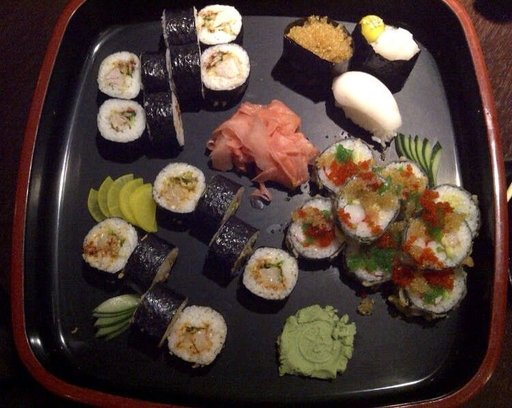

In [7]:
import random
from PIL import Image

random.seed(42)

# 1. Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Pick a random image path
random_image_path = random.choice(image_path_list)
print(random_image_path)

# 3. Get image class from path name
random_image_class = random_image_path.parent.stem
print(random_image_path.parent)
print(random_image_class)

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Random image class: {random_image_class}")
print(f"Random image dims: {img.height} x {img.width}")
img

Text(0.5, 1.0, 'sushi')

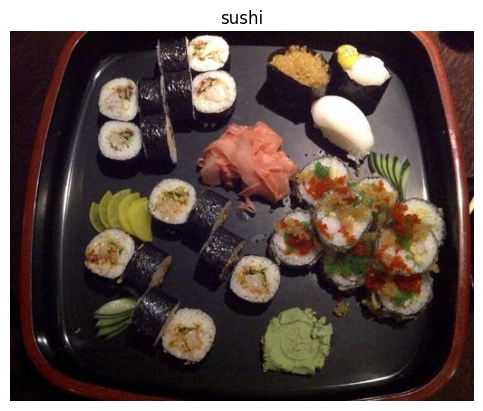

In [8]:
# Visualize  with matplotlib

import matplotlib.pyplot as plt

plt.imshow(img)
plt.axis(False)
plt.title(random_image_class)

In [9]:
import numpy as np
img_as_array = np.asarray(img)

img_as_array.shape

(408, 512, 3)

## 3. Transforming data

Need to convert data into Tensors before using with PyTorch

Also convert it into a `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`

In [10]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [11]:
data_transform = transforms.Compose([
    # Resize to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images (data augmentation) randomly on the horizontal
     transforms.RandomHorizontalFlip(p=0.5),
     # Turn image into a torch.Tensor
     transforms.ToTensor()
])

In [12]:
data_transform(img).shape

torch.Size([3, 64, 64])

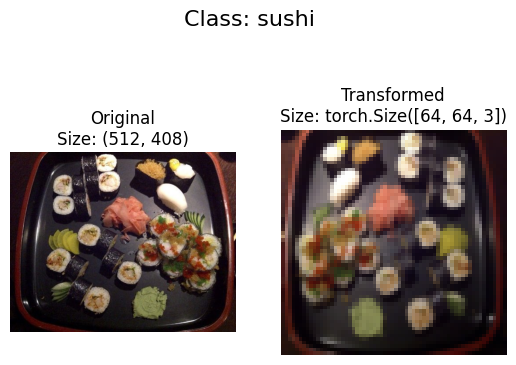

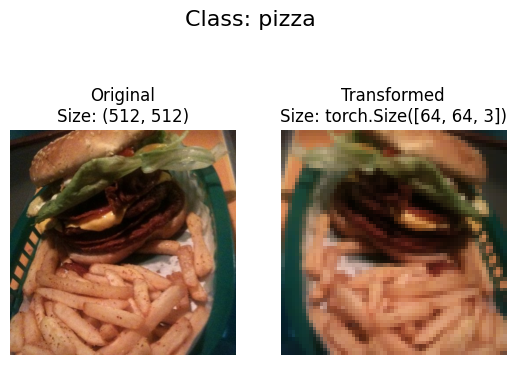

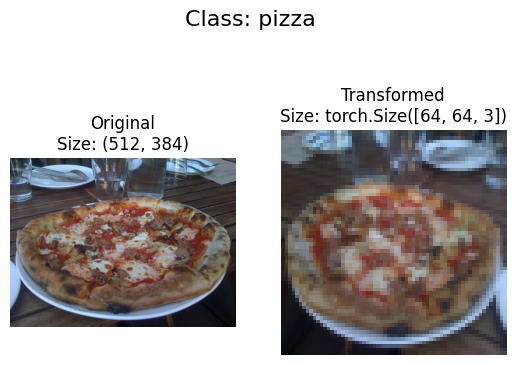

In [13]:
def plot_transformed_images(image_paths, transform, n=3, seed=None):
    '''Select random images from a path of random images and loads/transforms them, then plots original vs transformed'''
    if seed:
        random.seed(seed)

    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(nrows=1, ncols=2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original\nSize: {f.size}")
            ax[0].axis(False)

            # Transform and plot target image
            transformed_image = transform(f)
            transformed_image = torch.permute(transformed_image, (1, 2, 0))
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed\nSize: {transformed_image.shape}")
            ax[1].axis(False)

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=data_transform,
                        n=3,
                        seed=42)


## 4. Option 1: Loading image data using `ImageFolder`

Can load img classification data using `torchvision.datasets.ImageFolder`

In [14]:
# Use ImageFolder to create datasets
from torchvision import datasets

train_data = datasets.ImageFolder(root=train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_dir, transform=data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data\pizza_steak_sushi\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data\pizza_steak_sushi\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

In [15]:
# Get classnames as list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Get classnames as dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the lengths of our dataset
len(train_data), len(test_data)

(225, 75)

In [18]:
# Index on train_data Dataset to get a single image and label
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape:\n{img.shape}")
print(f"Image datatype:\n{img.dtype}")
print(f"Label:\n{label}")
print(f"Label datatype:\n{type(label)}")

Image tensor:
tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0902, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0745, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0157, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.01

In [19]:
class_names[label]

'pizza'

In [20]:
# Rearrange the oder dimensions
img_permute = img.permute(1, 2, 0)

(np.float64(-0.5), np.float64(63.5), np.float64(63.5), np.float64(-0.5))

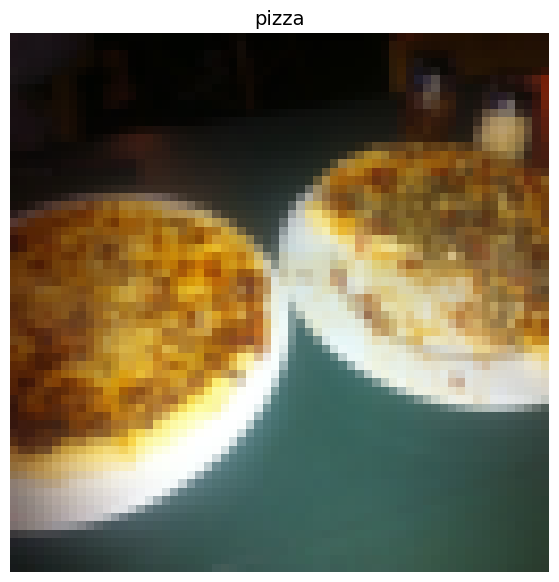

In [21]:
# Plot fig
plt.figure(figsize=(10, 7))
plt.imshow(img_permute)
plt.title(class_names[label], fontsize=14)
plt.axis(False)

### 4.1 Turn loaded images into `DataLoaders`

In [22]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data, batch_size=1, shuffle=True, num_workers=os.cpu_count())
test_dataloader = DataLoader(dataset=test_data, batch_size=1, shuffle=False, num_workers=os.cpu_count())

train_dataloader

In [23]:
len(train_dataloader), len(test_dataloader)

(225, 75)

In [24]:
img, label = next(iter(train_dataloader))
img.shape, label

(torch.Size([1, 3, 64, 64]), tensor([1]))

## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. Load images from file
2. Get classnames from Dataset
3. Get classes as dict from Dataset

Pros:
* Can create Dataset from almost anything
* Not limited to PyTorch prebuilt Dataset functions

Cons:
* Does not mean it will work
* Using a custom Dataset results in us writing more code, which could be prone to errors or performance issues


All custom datasets in PyTorch often subclass `torch.utils.data.Dataset` 

In [25]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [26]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating helper function to get classnames

1. Use `os.scandir()` to traverse a target directory and get classnames (ideally it is in standard image classification format)
2. Raise an error if classnames are not found
3. Turn the classnames into a dict and a list, and return them

In [27]:
# Set up path for target dir

target_directory = train_dir
print(f"Target dir: {target_directory}")

# get classnames from target dir
class_names_found = sorted([entry.name for entry in list(os.scandir(target_directory))])
class_names_found

Target dir: data\pizza_steak_sushi\train


['pizza', 'steak', 'sushi']

In [28]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
    '''Finds class folder names in a target directory.'''
    # get classnames from target dir
    classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

    # raise an error if class names could not be found
    if not classes:
        raise FileNotFoundError(f"Could not find any classes in {directory}")

    # create a directory of index labels
    class_to_idx = {class_name: i for i, class_name in enumerate(classes)} 
    return classes, class_to_idx

In [29]:
find_classes(target_directory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

1. Subclass `torch.utils.data.Dataset`
2. Init subclass with target directory as well as transform it (if needed)
3. Create attributes:
   1. paths
   2. transform
   3. classes
   4. class_to_idx
4. Create func `load_images()`
5. Overwrite the `__len()__` method to return length
6. Overwrite `__getitem()__` to return sample when passed an index

In [30]:
# Write a custom dataset class
from torch.utils.data import Dataset

# 1. subclass Dataset
class ImageFolderCustom(Dataset):
    # 2. Initialize custom dataset
    def __init__(self, targ_dir: str, transform=None):
        # 3. Create class attr
        # Get all img paths
        self.paths = list(pathlib.Path(targ_dir).glob('*/*.jpg'))
        # Setup transform
        self.transform = transform
        # Create classes and class_to_idx attr
        self.classes, self.class_to_idx = find_classes(targ_dir)

    # 4. Create a func to load images
    def load_image(self, index: int) -> Image.Image:
        '''Opens an image via a path and returns it.'''
        image_path = self.paths[index]
        return Image.open(image_path)
    
    # 5. Overwrite __len__()
    def __len__(self) -> int:
        '''Returns total number of samples.'''
        return len(self.paths)
    
    # 6. Overwrite __getitem__()
    def __getitem__(self, index) -> Tuple[torch.Tensor, int]:
        '''Returns one sample of data, data and label (X, y).'''
        img = self.load_image(index)
        class_name = self.paths[index].parent.name # expects path in format data_folder/class_name/image/jpg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx
        else:
            return img, class_idx

In [31]:
# Create a transform
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_transforms = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [32]:
# Test ImageFolderCustom
train_data_custom = ImageFolderCustom(targ_dir=train_dir, transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir=test_dir, transform=test_transforms)

In [33]:
train_data_custom

In [34]:
train_data

Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )

In [35]:
len(train_data), len(train_data_custom)

(225, 225)

In [36]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [37]:
# Check for equality b/w ImageFolder and ImageFolderCustom
print(train_data.classes == train_data_custom.classes)
print(test_data.classes == test_data_custom.classes)

True
True


### 5.3 Create a function to display random images

1. Take in a `Dataset` and number of other params such as class names and how many images to visualize
2. To prevent the display getting out of hand, cap number of images to 10
3. Set random seed
4. Get list of random sample indexes from target dataset
5. Set up matplotlib plot
6. Loop through the sample images and plot them
7. Make sure dims of images line up with matplotlib

In [38]:
# 1. Create func
def display_random_images(dataset: torch.utils.data.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):
    # 2. Adjust dispplay if n is too high
    if n > 10:
        n = 10
        display_shape = False
        print(f"n should be <= 10. Setting n = 10 and removing shape display.")

    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Set up plot
    plt.figure(figsize=(16, 8))

    # 6. Loop thru random indexes & plot them
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust tensor dims for plotting
        targ_image_adjusted = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(1, n, i+1)
        plt.imshow(targ_image_adjusted)
        plt.axis(False)
        if classes:
            title = f"Class: {classes[targ_label]}"
            if display_shape:
                title += f"\nShape: {targ_image_adjusted.shape}"
        plt.title(title)

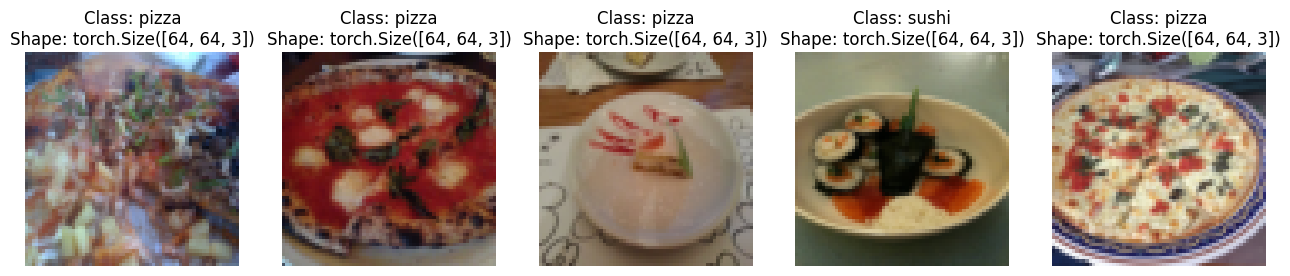

In [39]:
display_random_images(train_data, train_data.classes, 5, True, None)

n should be <= 10. Setting n = 10 and removing shape display.


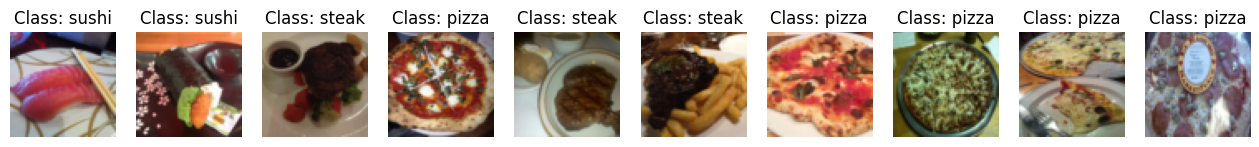

In [40]:
display_random_images(train_data_custom, train_data.classes, 11, True, None)

## 6. Turning custom `Dataset` into `DataLoader`

In [41]:
train_dataloader_custom = DataLoader(dataset=train_data_custom, batch_size=32, shuffle=True, num_workers=0)
test_dataloader_custom = DataLoader(dataset=test_data_custom, batch_size=32, shuffle=False, num_workers=0)

In [42]:
train_dataloader_custom

In [43]:
img, label = next(iter(train_dataloader_custom))
img.shape, label.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

## 7. Data Augmentation

In [44]:
# TrivialAugment
from torchvision import transforms

train_tranform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=5),
    transforms.ToTensor()
])

test_tranform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

In [45]:
# Get all img paths
image_path_list = list(image_path.glob('*/*/*.jpg'))
image_path_list[:10]

[WindowsPath('data/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('data/pizza_steak_sushi/test/pizza/2124579.jpg')]

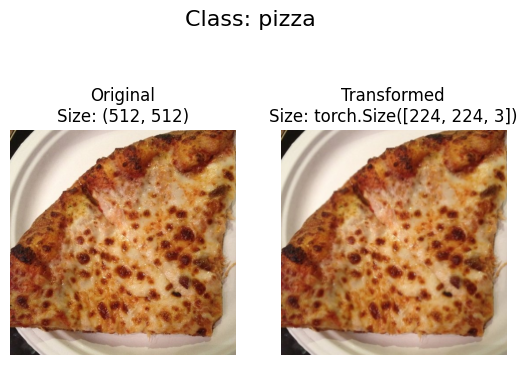

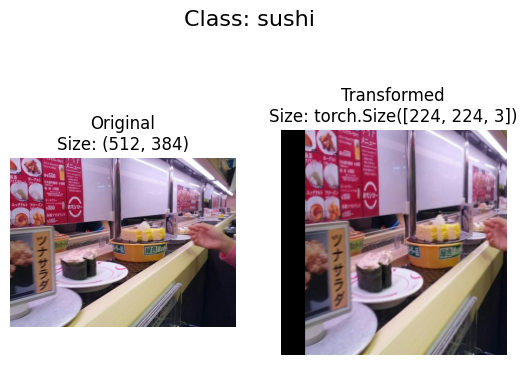

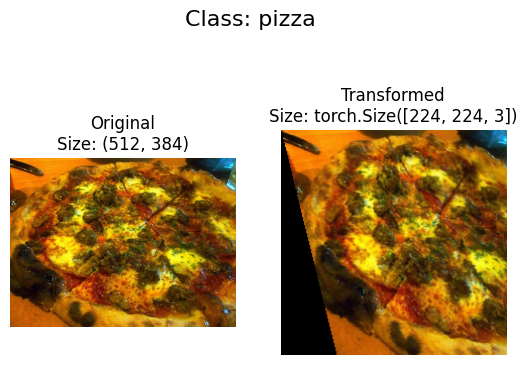

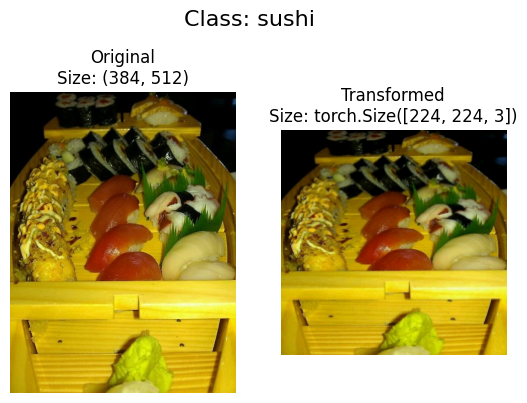

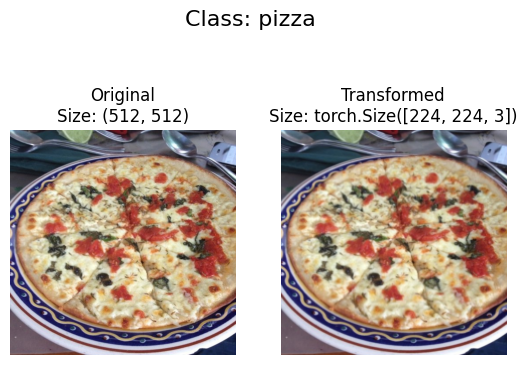

In [46]:
# Plot rand transformed images
plot_transformed_images(image_paths=image_path_list, transform=train_tranform, n=5, seed=None)

## 8. Model 0: TinyVGG w/o data augmentation

### 8.1 Creating transforms and loading data for model 0

In [47]:
simple_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [48]:
# 1. Load and transform data
train_data_simple = datasets.ImageFolder(train_dir, simple_transform)
test_data_simple = datasets.ImageFolder(test_dir, simple_transform)

# 2. Turn datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)

### 8.2 Create TinyVGG model class

In [49]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*4*4, out_features=output_shape)
        )

    def forward(self, X):
        # X = self.conv_block_1(X)
        # print(X.shape)
        # X = self.conv_block_2(X)
        # print(X.shape)
        # X = self.conv_block_3(X)
        # print(X.shape)
        # X = self.classifier(X)
        return self.classifier(self.conv_block_3(self.conv_block_2(self.conv_block_1(X))))

In [50]:
model_0 = TinyVGG(input_shape=3, hidden_units=32, output_shape=len(class_names)).to(device=device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=512, out_features=3, bias=True)
  )
)

### 8.3 Try forward pass on a single image

In [51]:
image_batch, label_batch = next(iter(train_dataloader_simple))

print(image_batch.size())

torch.Size([32, 3, 64, 64])


In [52]:
model_0(image_batch.to(device))

tensor([[ 0.0153, -0.0031, -0.0200],
        [ 0.0147, -0.0033, -0.0200],
        [ 0.0154, -0.0036, -0.0198],
        [ 0.0150, -0.0033, -0.0200],
        [ 0.0146, -0.0034, -0.0201],
        [ 0.0149, -0.0027, -0.0199],
        [ 0.0144, -0.0033, -0.0200],
        [ 0.0151, -0.0033, -0.0198],
        [ 0.0148, -0.0030, -0.0202],
        [ 0.0150, -0.0036, -0.0199],
        [ 0.0148, -0.0032, -0.0203],
        [ 0.0148, -0.0035, -0.0204],
        [ 0.0145, -0.0035, -0.0204],
        [ 0.0142, -0.0033, -0.0204],
        [ 0.0150, -0.0038, -0.0199],
        [ 0.0152, -0.0034, -0.0205],
        [ 0.0147, -0.0032, -0.0201],
        [ 0.0142, -0.0035, -0.0199],
        [ 0.0149, -0.0032, -0.0200],
        [ 0.0151, -0.0035, -0.0199],
        [ 0.0145, -0.0031, -0.0201],
        [ 0.0148, -0.0032, -0.0201],
        [ 0.0147, -0.0035, -0.0198],
        [ 0.0149, -0.0035, -0.0201],
        [ 0.0149, -0.0032, -0.0199],
        [ 0.0147, -0.0033, -0.0201],
        [ 0.0149, -0.0036, -0.0199],
 

### 8.4 Use torchinfo to get model summary and idea about shapes going through the model

In [53]:
try:
    from torchinfo import summary
except:
    %pip install torchinfo
    from torchinfo import summary

summary(model_0, input_size=(BATCH_SIZE, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 32, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 32, 62, 62]          896
│    └─ReLU: 2-2                         [32, 32, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 32, 60, 60]          9,248
│    └─ReLU: 2-4                         [32, 32, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 32, 30, 30]          --
├─Sequential: 1-2                        [32, 32, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 32, 28, 28]          9,248
│    └─ReLU: 2-7                         [32, 32, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 32, 26, 26]          9,248
│    └─ReLU: 2-9                         [32, 32, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 32, 13, 13]          --
├─Seq

### 8.5 Create train and test loop functions

In [54]:
from torchmetrics import Accuracy

In [55]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               acc_fn: Accuracy,
               device: torch.device = device):
    '''Performs training with model trying to learn on data_loader'''
    train_loss, train_acc = 0, 0

    model.train()

    acc_fn = acc_fn.to(device)

    # Add a loop to loop through the training batch
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)

        # Forward pass
        y_pred = model(X)

        # Loss
        loss = loss_fn(y_pred, y)
        train_loss += loss # accumulate training loss

        train_acc += acc_fn(y_pred.argmax(dim=1), y)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
    
    # Divide total training loss and accuracy by length of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f}")
    return train_loss.detach().to("cpu"), train_acc.to("cpu")

In [56]:
def test_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               acc_fn: Accuracy,
               device: torch.device = device):
    '''Performs testing with model going over data_loader'''
    test_loss, test_acc = 0, 0
    
    model.eval()

    acc_fn = acc_fn.to(device)

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            # Forward pass
            test_pred = model(X)

            # Loss
            test_loss += loss_fn(test_pred, y)

            # Accuracy
            test_acc += acc_fn(test_pred.argmax(dim=1), y)

        # Calculate avg. test loss per batch
        test_loss /= len(data_loader)

        # Calculate test accuracy avg. per batch
        test_acc /= len(data_loader)

        print(f"Test loss: {test_loss:.5f}, Test acc: {test_acc:.5f}")
        return test_loss.to("cpu"), test_acc.to("cpu")

### 8.6 Create `train()` function which trains a model

In [57]:
def train(model: nn.Module, train_dataloader: DataLoader, test_dataloader: DataLoader, loss_fn: nn.Module, optimizer: torch.optim.Optimizer, acc_fn: Accuracy, epochs: int, seed: int = None, device: torch.device = None):
    if seed:
        torch.manual_seed(seed)

    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": [],
               }

    for epoch in range(epochs):
        print(f"Epoch: {epoch}\n------")
        train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, acc_fn, device)
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, acc_fn, device)

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

### 8.7 Train and evaluate Model 0

In [58]:
from timeit import default_timer as timer

model_0 = TinyVGG(input_shape=3, hidden_units=64, output_shape=len(class_names)).to(device=device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)
acc_fn = Accuracy(task='multiclass', num_classes=len(class_names))

start_time = timer()
model_0_results = train(model=model_0, train_dataloader=train_dataloader_simple, test_dataloader=test_dataloader_simple, loss_fn=loss_fn, optimizer=optimizer, acc_fn=acc_fn, epochs=10, seed=42, device=device)
stop_time = timer()

model_0_results, stop_time-start_time

Epoch: 0
------
Train loss: 1.10232 | Train acc: 0.25000
Test loss: 1.09680, Test acc: 0.42140
Epoch: 1
------
Train loss: 1.08175 | Train acc: 0.46094
Test loss: 1.08506, Test acc: 0.29167
Epoch: 2
------
Train loss: 1.07001 | Train acc: 0.49609
Test loss: 1.09651, Test acc: 0.31250
Epoch: 3
------
Train loss: 1.04499 | Train acc: 0.45312
Test loss: 1.01331, Test acc: 0.31155
Epoch: 4
------
Train loss: 0.97549 | Train acc: 0.63672
Test loss: 1.03771, Test acc: 0.40341
Epoch: 5
------
Train loss: 1.01864 | Train acc: 0.50000
Test loss: 1.02448, Test acc: 0.43371
Epoch: 6
------
Train loss: 0.81736 | Train acc: 0.64453
Test loss: 1.07649, Test acc: 0.49527
Epoch: 7
------
Train loss: 0.84528 | Train acc: 0.66016
Test loss: 1.38332, Test acc: 0.30208
Epoch: 8
------
Train loss: 1.06980 | Train acc: 0.58594
Test loss: 0.98492, Test acc: 0.63542
Epoch: 9
------
Train loss: 0.97234 | Train acc: 0.42969
Test loss: 1.04025, Test acc: 0.53409


({'train_loss': [tensor(1.1023),
   tensor(1.0818),
   tensor(1.0700),
   tensor(1.0450),
   tensor(0.9755),
   tensor(1.0186),
   tensor(0.8174),
   tensor(0.8453),
   tensor(1.0698),
   tensor(0.9723)],
  'train_acc': [tensor(0.2500),
   tensor(0.4609),
   tensor(0.4961),
   tensor(0.4531),
   tensor(0.6367),
   tensor(0.5000),
   tensor(0.6445),
   tensor(0.6602),
   tensor(0.5859),
   tensor(0.4297)],
  'test_loss': [tensor(1.0968),
   tensor(1.0851),
   tensor(1.0965),
   tensor(1.0133),
   tensor(1.0377),
   tensor(1.0245),
   tensor(1.0765),
   tensor(1.3833),
   tensor(0.9849),
   tensor(1.0403)],
  'test_acc': [tensor(0.4214),
   tensor(0.2917),
   tensor(0.3125),
   tensor(0.3116),
   tensor(0.4034),
   tensor(0.4337),
   tensor(0.4953),
   tensor(0.3021),
   tensor(0.6354),
   tensor(0.5341)]},
 100.98671610001475)

### 8.8 Plot loss curves of Model 0

In [59]:
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [60]:
# for entry in model_0_results:
#     for i, point in enumerate(model_0_results[entry]):
#         model_0_results[entry][i] = model_0_results[entry][i].to("cpu")

# model_0_results

In [61]:
def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    acc = results["train_acc"]
    test_acc = results["test_acc"]

    epochs = range(len(loss))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label="train_acc")
    plt.plot(epochs, test_acc, label="test_acc")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

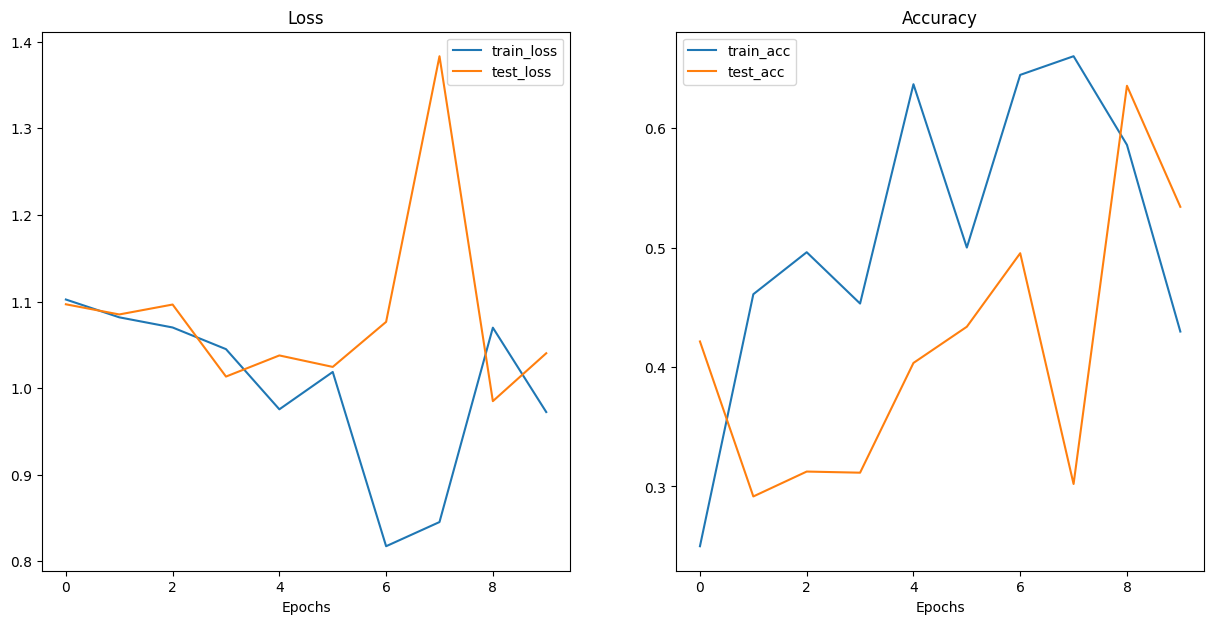

In [62]:
plot_loss_curves(model_0_results)

## 9. Model 1: TinyVGG with Data Augmentation

### 9.1 Create transform with data augmentation

In [63]:
from torchvision import transforms
train_transform_trivial = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=5),
    transforms.ToTensor()
])

test_transform_simple = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

### 9.2 Create train and test datasets and data loaders

In [64]:
train_data_augmented = datasets.ImageFolder(train_dir, train_transform_trivial)
test_data_simple = datasets.ImageFolder(test_dir, test_transform_simple)

# 2. Turn datasets into DataLoaders
import os
from torch.utils.data import DataLoader

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

train_dataloader_augmented = DataLoader(dataset=train_data_augmented,
                                     batch_size=BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_datalaoder_simple = DataLoader(dataset=test_data_simple,
                                     batch_size=BATCH_SIZE,
                                     shuffle=False,
                                     num_workers=NUM_WORKERS)

### 9.3 Create new TinyVGG class 

In [65]:
class TinyVGGV1(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units,
                      kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*4*4, out_features=output_shape)
        )

    def forward(self, X):
        # X = self.conv_block_1(X)
        # print(X.shape)
        # X = self.conv_block_2(X)
        # print(X.shape)
        # X = self.conv_block_3(X)
        # print(X.shape)
        # X = self.classifier(X)
        return self.classifier(self.conv_block_3(self.conv_block_2(self.conv_block_1(X))))

In [66]:
image_batch, label_batch = next(iter(train_dataloader_simple))

print(image_batch.size())

torch.Size([32, 3, 64, 64])


In [67]:
model_1 = TinyVGGV1(input_shape=3, hidden_units=64, output_shape=len(class_names)).to(device)
model_1

TinyVGGV1(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1024, out_features=3, bias=True)
  )
)

In [68]:
model_1(image_batch.to(device))

tensor([[-0.0351, -0.0301,  0.0207],
        [-0.0349, -0.0301,  0.0210],
        [-0.0353, -0.0302,  0.0206],
        [-0.0349, -0.0303,  0.0211],
        [-0.0348, -0.0302,  0.0211],
        [-0.0349, -0.0303,  0.0209],
        [-0.0346, -0.0303,  0.0212],
        [-0.0343, -0.0297,  0.0211],
        [-0.0345, -0.0299,  0.0210],
        [-0.0348, -0.0302,  0.0208],
        [-0.0340, -0.0297,  0.0214],
        [-0.0348, -0.0300,  0.0211],
        [-0.0346, -0.0303,  0.0204],
        [-0.0346, -0.0303,  0.0201],
        [-0.0342, -0.0299,  0.0206],
        [-0.0348, -0.0301,  0.0206],
        [-0.0347, -0.0300,  0.0207],
        [-0.0346, -0.0304,  0.0207],
        [-0.0345, -0.0306,  0.0209],
        [-0.0347, -0.0302,  0.0208],
        [-0.0347, -0.0301,  0.0210],
        [-0.0349, -0.0300,  0.0206],
        [-0.0343, -0.0296,  0.0211],
        [-0.0343, -0.0301,  0.0211],
        [-0.0346, -0.0298,  0.0207],
        [-0.0348, -0.0295,  0.0212],
        [-0.0346, -0.0301,  0.0206],
 

In [69]:
try:
    from torchinfo import summary
except:
    %pip install torchinfo
    from torchinfo import summary

summary(model_1, input_size=(BATCH_SIZE, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGGV1                                [32, 3]                   --
├─Sequential: 1-1                        [32, 64, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 64, 62, 62]          1,792
│    └─ReLU: 2-2                         [32, 64, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 64, 60, 60]          36,928
│    └─ReLU: 2-4                         [32, 64, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 64, 30, 30]          --
├─Sequential: 1-2                        [32, 64, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 64, 28, 28]          36,928
│    └─ReLU: 2-7                         [32, 64, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 64, 26, 26]          36,928
│    └─ReLU: 2-9                         [32, 64, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 64, 13, 13]          --


### 9.4 Train on Model 1

In [70]:
from timeit import default_timer as timer

model_1 = TinyVGGV1(input_shape=3, hidden_units=64, output_shape=len(class_names)).to(device=device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)
acc_fn = Accuracy(task='multiclass', num_classes=len(class_names))

start_time = timer()
model_1_results = train(model=model_1, train_dataloader=train_dataloader_augmented, test_dataloader=test_dataloader_simple, loss_fn=loss_fn, optimizer=optimizer, acc_fn=acc_fn, epochs=10, seed=42, device=device)
stop_time = timer()

model_1_results, stop_time-start_time

Epoch: 0
------
Train loss: 1.10169 | Train acc: 0.25000
Test loss: 1.09525, Test acc: 0.54167
Epoch: 1
------
Train loss: 1.07769 | Train acc: 0.42578
Test loss: 1.12494, Test acc: 0.26042
Epoch: 2
------
Train loss: 1.10529 | Train acc: 0.42969
Test loss: 1.09661, Test acc: 0.27083
Epoch: 3
------
Train loss: 1.05671 | Train acc: 0.53906
Test loss: 1.08154, Test acc: 0.38352
Epoch: 4
------
Train loss: 1.01565 | Train acc: 0.54688
Test loss: 1.04443, Test acc: 0.31250
Epoch: 5
------
Train loss: 1.08706 | Train acc: 0.36719
Test loss: 1.04862, Test acc: 0.29167
Epoch: 6
------
Train loss: 0.98940 | Train acc: 0.52344
Test loss: 1.09223, Test acc: 0.26042
Epoch: 7
------
Train loss: 1.04795 | Train acc: 0.54297
Test loss: 1.05127, Test acc: 0.42424
Epoch: 8
------
Train loss: 1.03854 | Train acc: 0.43750
Test loss: 1.02017, Test acc: 0.34280
Epoch: 9
------
Train loss: 1.00261 | Train acc: 0.40625
Test loss: 1.01440, Test acc: 0.55492


({'train_loss': [tensor(1.1017),
   tensor(1.0777),
   tensor(1.1053),
   tensor(1.0567),
   tensor(1.0156),
   tensor(1.0871),
   tensor(0.9894),
   tensor(1.0479),
   tensor(1.0385),
   tensor(1.0026)],
  'train_acc': [tensor(0.2500),
   tensor(0.4258),
   tensor(0.4297),
   tensor(0.5391),
   tensor(0.5469),
   tensor(0.3672),
   tensor(0.5234),
   tensor(0.5430),
   tensor(0.4375),
   tensor(0.4062)],
  'test_loss': [tensor(1.0952),
   tensor(1.1249),
   tensor(1.0966),
   tensor(1.0815),
   tensor(1.0444),
   tensor(1.0486),
   tensor(1.0922),
   tensor(1.0513),
   tensor(1.0202),
   tensor(1.0144)],
  'test_acc': [tensor(0.5417),
   tensor(0.2604),
   tensor(0.2708),
   tensor(0.3835),
   tensor(0.3125),
   tensor(0.2917),
   tensor(0.2604),
   tensor(0.4242),
   tensor(0.3428),
   tensor(0.5549)]},
 100.10017230000813)

### 9.5 Plot loss curve

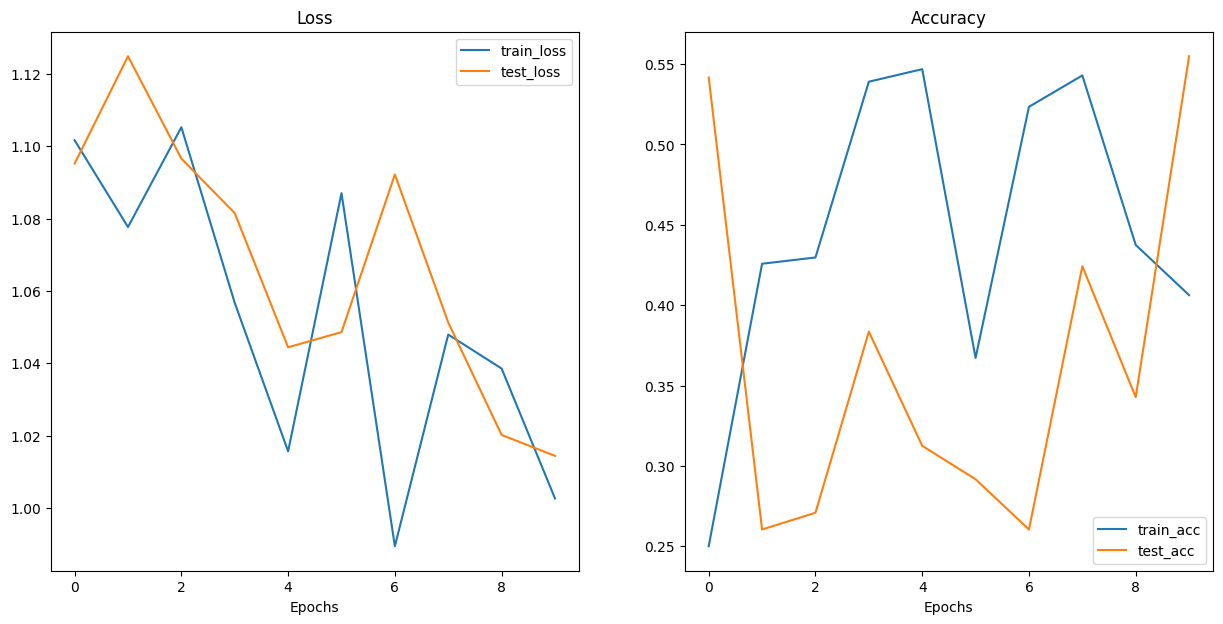

In [71]:
plot_loss_curves(model_1_results)

## 10. Comparing models

1. Hard coding
2. PyTorch + Tensorboard
3. [Weights & Biases](https://wandb.ai)
4. [MLFlow](https://mlflow.org)

In [72]:
import pandas as pd

model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

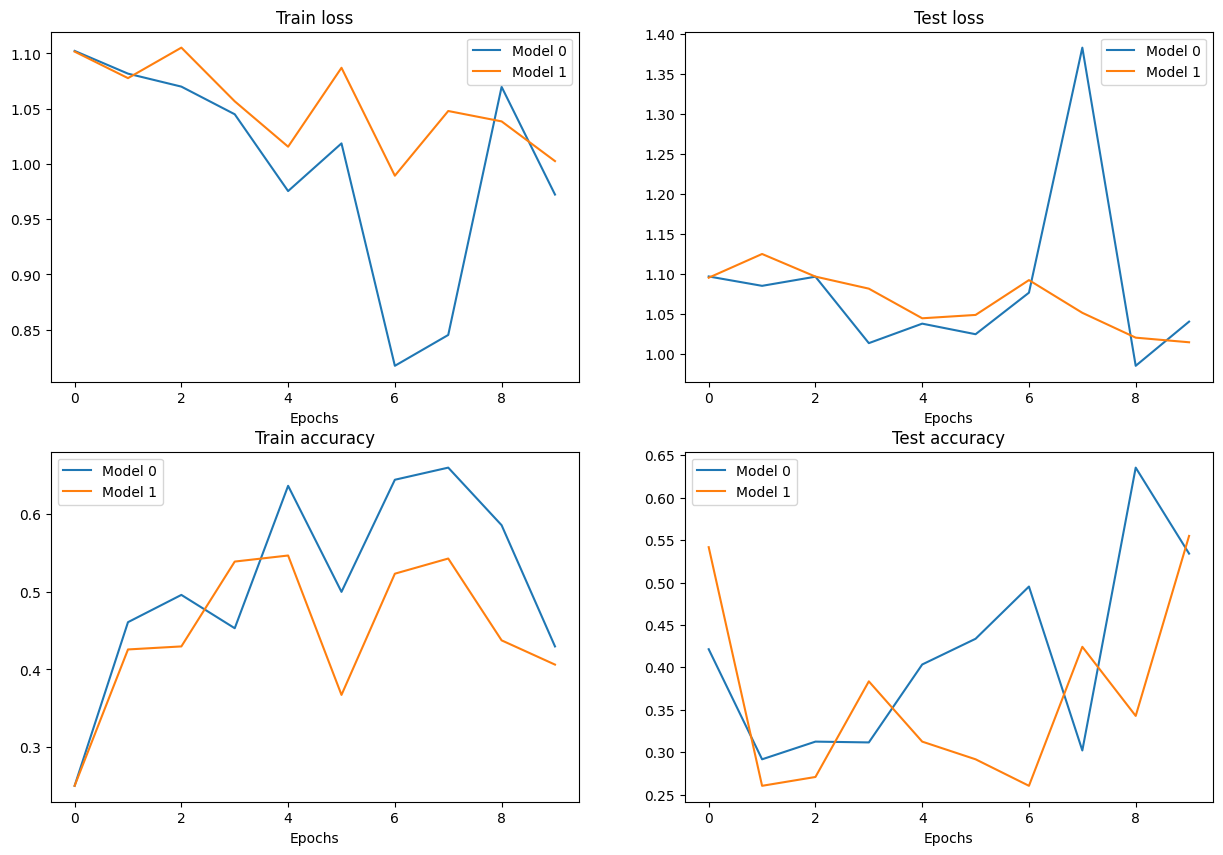

In [73]:
# Plot
plt.figure(figsize=(15, 10))

epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test accuracy")
plt.xlabel("Epochs")
plt.legend()

## 11. Model 2

In [74]:
from timeit import default_timer as timer

model_2 = TinyVGGV1(input_shape=3, hidden_units=256, output_shape=len(class_names)).to(device=device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_2.parameters(), lr=0.001)
acc_fn = Accuracy(task='multiclass', num_classes=len(class_names))

start_time = timer()
model_2_results = train(model=model_2, train_dataloader=train_dataloader_augmented, test_dataloader=test_dataloader_simple, loss_fn=loss_fn, optimizer=optimizer, acc_fn=acc_fn, epochs=20, seed=42, device=device)
stop_time = timer()

model_2_results, stop_time-start_time

Epoch: 0
------
Train loss: 1.15310 | Train acc: 0.34375
Test loss: 1.14155, Test acc: 0.26042
Epoch: 1
------
Train loss: 1.10959 | Train acc: 0.42578
Test loss: 1.10816, Test acc: 0.26042
Epoch: 2
------
Train loss: 1.09238 | Train acc: 0.42578
Test loss: 1.12110, Test acc: 0.26042
Epoch: 3
------
Train loss: 1.10276 | Train acc: 0.30469
Test loss: 1.12334, Test acc: 0.26042
Epoch: 4
------
Train loss: 1.08621 | Train acc: 0.42578
Test loss: 1.14424, Test acc: 0.26042
Epoch: 5
------
Train loss: 1.09958 | Train acc: 0.30859
Test loss: 1.13701, Test acc: 0.28125
Epoch: 6
------
Train loss: 1.09443 | Train acc: 0.41797
Test loss: 1.13661, Test acc: 0.19792
Epoch: 7
------
Train loss: 1.10475 | Train acc: 0.29297
Test loss: 1.13027, Test acc: 0.19792
Epoch: 8
------
Train loss: 1.10290 | Train acc: 0.37891
Test loss: 1.06910, Test acc: 0.27083
Epoch: 9
------
Train loss: 1.06569 | Train acc: 0.37891
Test loss: 0.94931, Test acc: 0.60417
Epoch: 10
------
Train loss: 1.11748 | Train acc: 

({'train_loss': [tensor(1.1531),
   tensor(1.1096),
   tensor(1.0924),
   tensor(1.1028),
   tensor(1.0862),
   tensor(1.0996),
   tensor(1.0944),
   tensor(1.1048),
   tensor(1.1029),
   tensor(1.0657),
   tensor(1.1175),
   tensor(1.0430),
   tensor(1.0657),
   tensor(1.0280),
   tensor(1.0290),
   tensor(0.9098),
   tensor(0.9441),
   tensor(0.9699),
   tensor(0.9598),
   tensor(0.9929)],
  'train_acc': [tensor(0.3438),
   tensor(0.4258),
   tensor(0.4258),
   tensor(0.3047),
   tensor(0.4258),
   tensor(0.3086),
   tensor(0.4180),
   tensor(0.2930),
   tensor(0.3789),
   tensor(0.3789),
   tensor(0.3984),
   tensor(0.4297),
   tensor(0.3945),
   tensor(0.5000),
   tensor(0.4141),
   tensor(0.5859),
   tensor(0.5547),
   tensor(0.4766),
   tensor(0.5781),
   tensor(0.4609)],
  'test_loss': [tensor(1.1415),
   tensor(1.1082),
   tensor(1.1211),
   tensor(1.1233),
   tensor(1.1442),
   tensor(1.1370),
   tensor(1.1366),
   tensor(1.1303),
   tensor(1.0691),
   tensor(0.9493),
   tenso

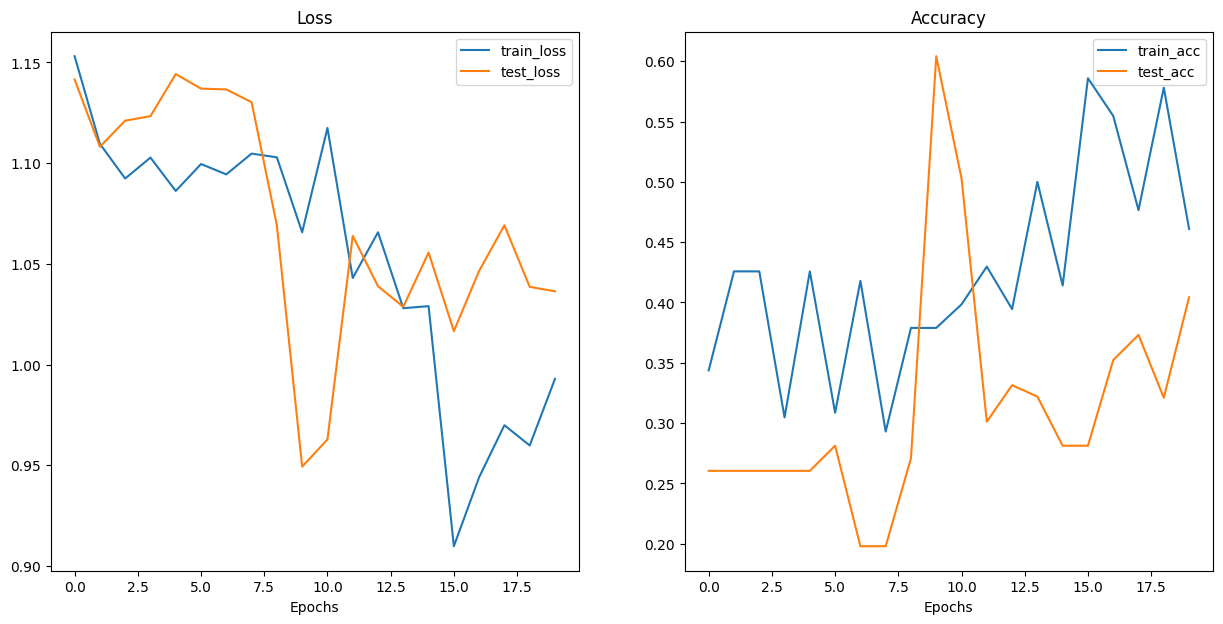

In [75]:
plot_loss_curves(model_2_results)

## 12. Making a prediction on a custom image

In [76]:
import requests

custom_image_path = data_path / "04-pizza-dad.jpeg"

if not custom_image_path.is_file():
    with open(custom_image_path, 'wb') as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists. Skipping download...")

### 12.1 Loading in a custom image with PyTorch

Ensure data is:

1. In tensor form with datatype torch.float32
2. Of shape 64x64x3
3. On the right device

In [77]:
import torchvision

custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

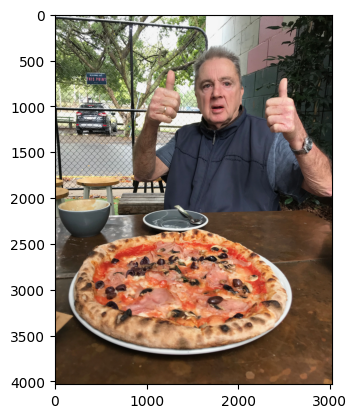

In [79]:
plt.imshow(custom_image_uint8.permute(1, 2, 0))

In [80]:
print(custom_image_uint8.shape)
print(custom_image_uint8.dtype)
print(custom_image_uint8.device)

torch.Size([3, 4032, 3024])
torch.uint8
cpu


### 12.2 Making a prediction on a custom image with trained PyTorch model

In [83]:
# Load custom image & convert to torch.float32

custom_image = custom_image_uint8.type(dtype=torch.float32) / 255.
custom_image

tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..., 0.0549, 0.0510, 0.

In [84]:
# Transform custom image
from torchvision import transforms

transform_pipeline = transforms.Compose([
    transforms.Resize(size=(64, 64))
])

custom_image_transformed = transform_pipeline(custom_image)
custom_image_transformed.shape

torch.Size([3, 64, 64])

### 12.3 Add batch size

In [92]:
custom_image_transformed = custom_image_transformed.unsqueeze(dim=0)
custom_image_transformed.shape

torch.Size([1, 1, 3, 64, 64])

In [91]:
model_2.eval()

with torch.inference_mode():
    custom_image_pred = model_2(custom_image_transformed.to(device))

custom_image_pred

tensor([[ 0.0044,  0.1418, -0.4101]], device='cuda:0')

In [90]:
class_names

['pizza', 'steak', 'sushi']

In [93]:
custom_image_pred_probs = custom_image_pred.softmax(dim=1)
custom_image_pred_probs

tensor([[0.3561, 0.4086, 0.2353]], device='cuda:0')

In [96]:
custom_image_pred_labels = custom_image_pred_probs.argmax(dim=1).cpu()
custom_image_pred_labels

tensor([1])

In [98]:
class_names[custom_image_pred_labels] # wrong because model is not good

'steak'

### 12.3 Putting custom img prediction together: Building a function

In [111]:
def pred_and_plot_image(model: nn.Module,
                        image_path: str,
                        class_names: List[str] = None,
                        transform = None,
                        device = device):
    '''Make prediction on target image with trained model and plot the image and prediction'''

    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # Divide img pixel vals by 255 to get them b/w [0, 1)
    target_image /= 255.

    if transform is not None:
        target_image = transform(target_image)

    model.to(device)

    model.eval()

    with torch.inference_mode():
        # add batch dim to image
        target_image = target_image.unsqueeze(0)

        pred_logits = model(target_image.to(device))

        pred_probs = pred_logits.softmax(1)

        pred_label = pred_probs.argmax(1)

    plt.imshow(target_image.squeeze().permute(1, 2, 0))
    if class_names is not None:
        plt.title(f"Pred: {class_names[pred_label.cpu()]} | Prob: {pred_probs.max().cpu():.3f}")
    else:
        plt.title(f"Pred: {pred_label} | Prob: {pred_probs.max().cpu():.3f}")
    plt.axis(False)

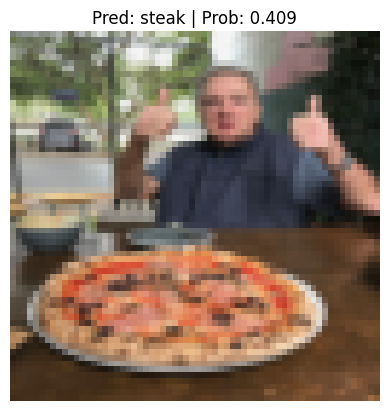

In [112]:
pred_and_plot_image(model_2, custom_image_path, class_names, transform_pipeline, device)